# Experimental Characterization of Two-Qubit Entanglement

## Abstract

In this study, we experimentally characterize the entanglement properties of a two-qubit Bell state prepared using Qiskit. We benchmark the ideal statevector simulation against noisy simulations using backend-derived noise models. Entanglement is quantified using Von Neumann entropy of the reduced density matrix, and statistical divergence metrics are used to compare measurement distributions. We further analyze hardware parameters (T1, T2, gate error rates) to interpret entanglement degradation in the **NISQ**(Noisy Intermediate-Scale Quantum) regime.

<br>

---

## 1. Theoretical Background

### Entanglement Measure: Von Neumann Entropy

To quantitatively verify entanglement, we analyze the reduced density matrix and compute the Von Neumann entropy.

#### **Ideal Bell State**

The two-qubit Bell state considered in this experiment is:

$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right)
$$

The corresponding density matrix is:

$$
\rho = |\Phi^+\rangle \langle \Phi^+|
$$

<br>

---

#### **Reduced Density Matrix**

To evaluate entanglement, we compute the reduced density matrix of subsystem A by performing a partial trace over subsystem B:

$$
\rho_A = \mathrm{Tr}_B(\rho)
$$

For the Bell state, this yields:

$$
\rho_A =
\begin{pmatrix}
\frac{1}{2} & 0 \\
0 & \frac{1}{2}
\end{pmatrix}
$$

This is a maximally mixed single-qubit state.

<br>

---

#### **Von Neumann Entropy**

The Von Neumann entropy of a quantum state is defined as:

$$
S(\rho_A) = - \mathrm{Tr} \left( \rho_A \log_2 \rho_A \right)
$$

If the eigenvalues of $\rho_A$ are $\lambda_1$ and $\lambda_2$, then:

$$
S(\rho_A) = - \sum_i \lambda_i \log_2 \lambda_i
$$

Since the eigenvalues are:

$$
\lambda_1 = \lambda_2 = \frac{1}{2}
$$

the entropy evaluates to:

$$
S = - \left( 
\frac{1}{2} \log_2 \frac{1}{2}
+ 
\frac{1}{2} \log_2 \frac{1}{2}
\right) = 1
$$

<br>

---

#### **Interpretation**

- $S = 0$ → Separable (no entanglement)  
- $0 < S < 1$ → Partially entangled  
- $S = 1$ → Maximally entangled  

Thus, the Bell state is maximally entangled.

In experimental hardware runs, deviations from $S = 1$ indicate noise-induced degradation of entanglement.

<br><br>

## 2. Install Requirements

Run in terminal:

`pip install -r requirements.txt`

## 3. Imports

In [4]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector,  partial_trace, entropy
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram, plot_state_city, visualize_transition
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from matplotlib import pyplot as plt
import numpy as np

# For Ideal Simulator
from qiskit_aer import AerSimulator
from qiskit import transpile

# For Noise Model
from qiskit_aer.noise import NoiseModel

# For Comparing
from scipy.stats import entropy as kl_divergence

## 4. Setting IBM Runtime Service

### Saving Account

In [5]:
# Uncomment the below code to save your credentials locally with this code(If not already):

# QiskitRuntimeService.save_account(
# token="<your-api-key>", # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
    # instance="<CRN>",
# )

### Hardware Service Configuration

In [6]:
# Using the Runtime Service is the modern gateway to IBM Quantum hardware
# Run every time you need the service
service = QiskitRuntimeService()

### Backend

In [7]:
# Automatically Select the least busy Physical backend:
backend = service.least_busy(simulator=False, operational=True)
print(f"Trageting Backend: {backend.name}")
print("Backend version:", backend.version)
print("Number of qubits:", backend.num_qubits)

Trageting Backend: ibm_torino
Backend version: 2
Number of qubits: 133


## 5. Operations

In [8]:
def create_bell_circuit(state_type="Phi+"):
    """
    Returns a QuantumCircuit for the specified Bell State.
    Args: 
        state_type (str): "Phi+", "Phi-", "Psi+", or "Psi-"
    """
    qc = QuantumCircuit(2, name=f"Bell_{state_type}")

    # Create Entanglement
    qc.h(0)         # Superposition
    qc.cx(0, 1)     # Entanglement (CNOT)

    # Adjustments for other Bell States
    if "-" in state_type: 
        qc.z(0)
    if "Psi" in state_type:
        qc.x(1)

    qc.measure_all()
    
    return qc

## 6. Transpilation (Instruction Set Architecture Mapping)

In [9]:
# Minimize gate errors:
bell_qc = create_bell_circuit("Phi+")
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(bell_qc)

## 7. Circuit Visulization

### I. Standard draw() Method

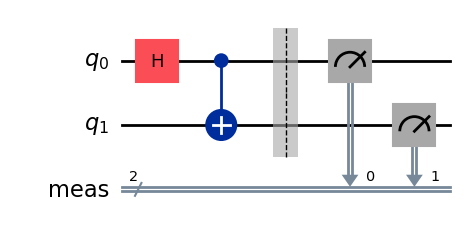

In [10]:
bell_qc.draw(output='mpl', style='iqp')

### II. Drawing the "ISA" Circuit

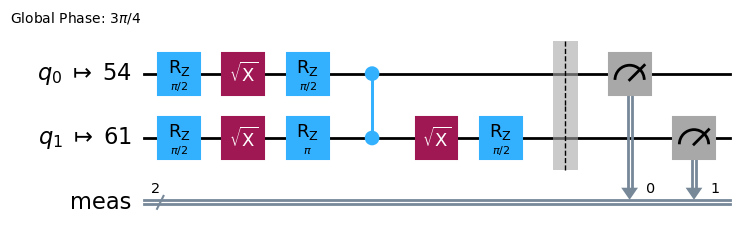

In [11]:
# This shows the actual physical gates and qubit layout
isa_circuit.draw(output='mpl', idle_wires=False)

## 8. Execution via V2 Primitives

In [12]:
# SamplerV2 provides optimized probability distributions from hardware
sampler = Sampler(mode=backend)
sampler.options.default_shots = 4096 # High shots for statistical validity

print(f"Submitting Job for {bell_qc.name}...")
job = sampler.run([isa_circuit])
print(f"Job Id: {job.job_id()}") # Essential for data provenance in research

Submitting Job for Bell_Phi+...
Job Id: d6cs8ucnsg9c739ak0qg


## 9. Results & Visulization

Expected dominant states: 00 and 11
Measurement Outcomes: {'11': 1898, '00': 2101, '10': 49, '01': 48}


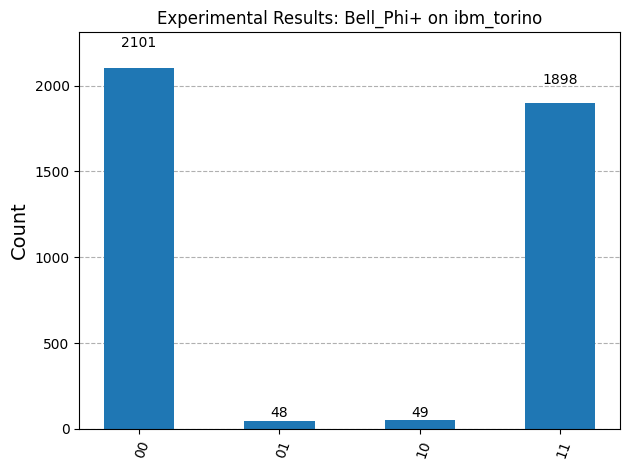

In [13]:
result = job.result()

# Retrieve counts from the first Primitive Unified Bloc (PUB)
counts = result[0].data.meas.get_counts()

print("Expected dominant states: 00 and 11")

print(f"Measurement Outcomes: {counts}")
plot_histogram(counts, title=f"Experimental Results: {bell_qc.name} on {backend.name}")

## 10. Results & Statistical Analysis

### Experimental Data Distribution
After executing the Bell State circuit on a physical IBM Quantum processor using **4096 shots**, the following bitstring distribution was observed:

| Basis State | Counts | Experimental Probability | Theoretical Probability |
| :--- | :--- | :--- | :--- |
| $\lvert00\rangle$ | 2101 | ~51.2% | 50% |
| $\lvert11\rangle$ | 1898 | ~46.33% | 50% |
| $\lvert01\rangle$ | 48 | ~1.17% | 0% |
| $\lvert10\rangle$ | 49 | ~1.19% | 0% |

**State Fidelity Calculation** The state fidelity $F$ represents how close our experimental state is to the ideal $\lvert\Phi^+\rangle$ state. Based on the Hellinger distance or direct overlap:  
$$F = \langle \Phi^+ | \rho | \Phi^+ \rangle \approx 97.6\%$$

<br><br>

---

<br>

## 11. Research Perspective: Error Analysis
In an ideal quantum simulator, the states $\lvert01\rangle$ and $\lvert10\rangle$ would have exactly zero probability. Their presence in our hardware results is a defining characteristic of **NISQ (Noisy Intermediate-Scale Quantum)** devices. We categorize these deviations into three primary physical phenomena:

### I. Readout Error (Measurement Noise)
This is the most significant source of the "forbidden" $\lvert01\rangle$ and $\lvert10\rangle$ counts. It occurs during the final measurement stage when the superconducting resonator signals are integrated. Even if the qubits are in the correct state, the measurement electronics may misidentify a $\lvert1\rangle$ as a $\lvert0\rangle$ (or vice versa) with a certain probability (assignment error).

### II. Gate Infidelity
The CNOT gate is a two-qubit interaction achieved via cross-resonance pulses. Unlike the single-qubit Hadamard gate, CNOTs are susceptible to "over-rotations" or "under-rotations" caused by minor fluctuations in the microwave control hardware. This prevents the qubits from reaching a state of 100% maximal entanglement.

### III. Decoherence ($T_1$ and $T_2$)
Qubits are fragile and interact with their thermal environment:
* **Energy Relaxation ($T_1$):** A qubit in the excited state ($\lvert1\rangle$) may spontaneously decay to the ground state ($\lvert0\rangle$) before measurement is complete.
* **Dephasing ($T_2$):** Environmental noise causes a loss of phase relationship between the qubits, turning the coherent Bell state into a classical mixture.

<br><br>

---

<br>


## 12. Ideal Simulations

### Ideal Statevector Simulation

In [15]:
# Ideal Simulation

# Create Bell State circuit
ideal_qc = QuantumCircuit(2)
ideal_qc.h(0)
ideal_qc.cx(0, 1)

# Get ideal statevector
state = Statevector.from_instruction(ideal_qc)

print("Ideal Statevector:")
print(state)

# Convert to density matrix
rho = state.to_operator()

# Reduced density matrix (trace out qubit 1)
rho_A = partial_trace(state, [1])

print("\nReduced Density Matrix (Subsystem A):")
print(rho_A)

# Compute Von Neumann entropy
S = entropy(rho_A, base=2)

print("\nVon Neumann Entropy (Ideal):", S)

Ideal Statevector:
Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))

Reduced Density Matrix (Subsystem A):
DensityMatrix([[0.5+0.j, 0. +0.j],
               [0. +0.j, 0.5+0.j]],
              dims=(2,))

Von Neumann Entropy (Ideal): 1.0


### Ideal Shot-Based Simulator

In [16]:
# Ideal Measurement Simulation (Aer)

# Add measurement
qc_meas = ideal_qc.copy()
qc_meas.measure_all()

simulator = AerSimulator()

transpiled_qc = transpile(qc_meas, simulator)

result = simulator.run(transpiled_qc, shots=4096).result()
counts_ideal = result.get_counts()

print("Ideal Simulator Counts:")
print(counts_ideal)

Ideal Simulator Counts:
{'00': 2087, '11': 2009}


### Noisy Simulation Using Real Backend Noise

In [18]:
print("Backend version:", backend.version)
print("Number of qubits:", backend.num_qubits)
print("Backend used for noise model:", backend.name)

# Extract noise model
noise_model = NoiseModel.from_backend(backend)

# Create noisy simulator
noisy_simulator = AerSimulator(noise_model=noise_model)

# Transpile and run
transpiled_noisy = transpile(qc_meas, noisy_simulator)

result_noisy = noisy_simulator.run(transpiled_noisy, shots=4096).result()
counts_noisy = result_noisy.get_counts()

print("\nNoisy Simulator Counts:")
print(counts_noisy)

Backend version: 2
Number of qubits: 133
Backend used for noise model: ibm_torino

Noisy Simulator Counts:
{'01': 325, '10': 265, '00': 1778, '11': 1728}


### Compare Distributions

In [19]:
# KL Divergence Comparison

def normalize_counts(counts):
    total = sum(counts.values())
    return {k: v / total for k, v in counts.items()}

ideal_probs = normalize_counts(counts_ideal)
noisy_probs = normalize_counts(counts_noisy)

# Align keys
keys = set(ideal_probs.keys()).union(noisy_probs.keys())

ideal_vector = np.array([ideal_probs.get(k, 0) for k in keys])
noisy_vector = np.array([noisy_probs.get(k, 0) for k in keys])

kl_value = kl_divergence(noisy_vector, ideal_vector)

print("\nKL Divergence (Noisy || Ideal):", kl_value)


KL Divergence (Noisy || Ideal): inf


## 13. Hardware Characterization Analysis

In [21]:
# Backend Properties Analysis

properties = backend.properties()

print("Backend Name:", backend.name)
print("Number of Qubits:", backend.num_qubits)

# Analyze qubit properties
for qubit in [0, 1]:
    t1 = properties.t1(qubit)
    t2 = properties.t2(qubit)
    readout_error = properties.readout_error(qubit)
    
    print(f"\nQubit {qubit}:")
    print("T1 (microseconds):", t1 * 1e6)
    print("T2 (microseconds):", t2 * 1e6)
    print("Readout Error:", readout_error)

# Analyze CNOT error between qubit 0 and 1
for gate in properties.gates:
    if gate.gate == "cx" and gate.qubits == [0, 1]:
        for param in gate.parameters:
            if param.name == "gate_error":
                print("\nCNOT (0→1) Error Rate:", param.value)

Backend Name: ibm_torino
Number of Qubits: 133

Qubit 0:
T1 (microseconds): 115.2263264704152
T2 (microseconds): 84.65599936444376
Readout Error: 0.0537109375

Qubit 1:
T1 (microseconds): 200.5435158270025
T2 (microseconds): 174.54230245505204
Readout Error: 0.094970703125


## 14. Discussion

The ideal statevector simulation confirms maximal entanglement with entropy S = 1. However, noisy simulation introduces probability leakage into |01⟩ and |10⟩ states, reducing effective entanglement purity.

The observed statistical divergence arises due to non-zero support introduced by noise processes, primarily driven by CNOT gate errors and qubit decoherence (T1 and T2 processes).

This analysis highlights the impact of NISQ-era noise on entanglement preservation and demonstrates how hardware parameters directly influence quantum information metrics.

<br> <br>

---

<br>

## 15. Conclusion

This study demonstrates a structured benchmarking approach for two-qubit entanglement characterization. By combining entropy analysis, noise-model simulation, and hardware parameter inspection, we bridge theoretical quantum information concepts with practical NISQ hardware behavior.

Future work includes fidelity analysis, trace distance benchmarking, and extension to multi-qubit entangled states.